# IFT712 Projet Fin de Session

------------------------------
MAHDI AIT LHAJ LOUTFI (aitm2302)  
YOVAN TURCOTTE (tury1903)



## Visualisation des données et analyse des résultats :
Dans ce Notebook, on va analyse les resultas de l'entrainement. Dans le fond on va choisir le modele avec la meilleur performance, et le tester sur les donnees de test.

In [254]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
sys.path.append("..")
#-------for Pre-Processing----
from sklearn.decomposition import PCA
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)
from src.DataProcesser.Processer import DataProcesser
#------------------------------
import src.Manager
from sklearn.metrics import confusion_matrix
import seaborn as sns
%reload_ext autoreload
%autoreload 2


## Charger les données :
Si la cellule suivante marche, ca veut dire que l'extraction des données marche tres bien.

In [255]:
DP = DataProcesser(seed = 16082604)
DP.importData(label_name = 'species')
print(f"The total dataset has {DP.df().shape[0]} observations with dimentionality {DP.df().shape[1]}.")
DP.df().head()

The total dataset has 990 observations with dimentionality 192.


,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,margin11,margin12,margin13,margin14,margin15,margin16,margin17,margin18,margin19,margin20,margin21,margin22,margin23,margin24,margin25,margin26,margin27,margin28,margin29,margin30,margin31,margin32,margin33,margin34,margin35,margin36,margin37,margin38,margin39,margin40,margin41,margin42,margin43,margin44,margin45,margin46,margin47,margin48,margin49,margin50,margin51,margin52,margin53,margin54,margin55,margin56,margin57,margin58,margin59,margin60,margin61,margin62,margin63,margin64,shape1,shape2,shape3,shape4,shape5,shape6,shape7,shape8,shape9,shape10,shape11,shape12,shape13,shape14,shape15,shape16,shape17,shape18,shape19,shape20,shape21,shape22,shape23,shape24,shape25,shape26,shape27,shape28,shape29,shape30,shape31,shape32,shape33,shape34,shape35,shape36,shape37,shape38,shape39,shape40,shape41,shape42,shape43,shape44,shape45,shape46,shape47,shape48,shape49,shape50,shape51,shape52,shape53,shape54,shape55,shape56,shape57,shape58,shape59,shape60,shape61,shape62,shape63,shape64,texture1,texture2,texture3,texture4,texture5,texture6,texture7,texture8,texture9,texture10,texture11,texture12,texture13,texture14,texture15,texture16,texture17,texture18,texture19,texture20,texture21,texture22,texture23,texture24,texture25,texture26,texture27,texture28,texture29,texture30,texture31,texture32,texture33,texture34,texture35,texture36,texture37,texture38,texture39,texture40,texture41,texture42,texture43,texture44,texture45,texture46,texture47,texture48,texture49,texture50,texture51,texture52,texture53,texture54,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,0.001953,0.033203,0.013672,0.019531,0.066406,0.000000,0.029297,0.0,0.031250,0.011719,0.000000,0.025391,0.023438,0.001953,0.0,0.015625,0.000000,0.031250,0.000000,0.013672,0.029297,0.015625,0.011719,0.003906,0.025391,0.000000,0.001953,0.011719,0.009766,0.041016,0.037109,0.019531,0.000000,0.009766,0.021484,0.015625,0.007812,0.013672,0.027344,0.062500,0.000000,0.017578,0.031250,0.0,0.044922,0.007812,0.025391,0.003906,0.013672,0.015625,0.013672,0.003906,0.005859,0.003906,0.019531,0.001953,0.000647,0.000609,0.000576,0.000553,0.000516,0.000496,0.000474,0.000453,0.000454,0.000429,0.000418,0.000410,0.000406,0.000398,0.000399,0.000389,0.000399,0.000416,0.000414,0.000430,0.000422,0.000437,0.000452,0.000467,0.000470,0.000484,0.000489,0.000490,0.000475,0.000486,0.000484,0.000500,0.000513,0.000511,0.000519,0.000513,0.000502,0.000498,0.000487,0.000471,0.000458,0.000440,0.000436,0.000427,0.000394,0.000385,0.000382,0.000370,0.000367,0.000373,0.000386,0.000389,0.000391,0.000414,0.000422,0.000434,0.000452,0.000471,0.000485,0.000512,0.000536,0.000553,0.000610,0.000661,0.049805,0.017578,0.003906,0.024414,0.001953,0.010742,0.035156,0.007812,0.039062,0.062500,0.000000,0.000000,0.007812,0.007812,0.0,0.0,0.047852,0.0,0.054688,0.022461,0.0,0.000977,0.018555,0.001953,0.008789,0.015625,0.044922,0.000000,0.037109,0.012695,0.028320,0.000000,0.019531,0.026367,0.005859,0.0,0.004883,0.016602,0.034180,0.056641,0.006836,0.000977,0.022461,0.037109,0.004883,0.021484,0.035156,0.000977,0.004883,0.015625,0.000000,0.0,0.006836,0.037109,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
2,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,0.000000,0.007812,0.003906,0.027344,0.023438,0.000000,0.033203,0.0,0.009766,0.009766,0.007812,0.007812,0.019531,0.007812,0.0,0.000000,0.007812,0.027344,0.003906,0.037109,0.007812,0.048828,0.054688,0.027344,0.003906,0.000000,0.000000,0.003906,0.013672,0.033203,0.033203,0.019531,0.031250,0.009766,0.007812,0.031250,0.001953,0.039062,0.029297,0.031250,0.035156,0.000

## Organisation et distribution des données :
1- On va premierement diviser les données d'entrainement,test et validation

2- Faire un Sanity Check


In [256]:
DP.split_data(test_ratio = 0.1)
print("Train + Validation dataset created")

Train + Validation dataset created


In [257]:
#Sanity Check
#Verifier que toutes les classes du test set figurent dans les train + validation sets
Diff = set(DP.labels_Test()) - set(DP.labels_Train()) #should be empty set
if(Diff == set()):
    print("Sanity Check Verified!")
else:
    print("Sanity Check Verification Failed!")
    raise ValueError("There are no training observations for the classes : "+ str(Diff))

Sanity Check Verified!


## Chargement de resultats

In [258]:
with open('../results/results.json') as f:
    results = json.load(f)
print(f'There are {len(results)} different models.')

There are 6562 different models.


In [259]:
#Calculating F1Score
for key in results:
    precision = np.float(results[key]['results']['Precision'])
    recall = np.float(results[key]['results']['Recall'])
    if(recall == 0.0 or precision == 0.0):
        results[key]['results']['F1Score'] = '0.000'
    else:
        results[key]['results']['F1Score'] = str(2.0 / (1.0 / precision + 1.0 / recall))[:5]

<ipython-input-259-165c7ca5f063>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  precision = np.float(results[key]['results']['Precision'])
<ipython-input-259-165c7ca5f063>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  recall = np.float(results[key]['results']['Recall'])


## Chercher le meilleur modele pour chaque classifieur

In [260]:
# Unique Classifiers type
classifiers = set(map(lambda x: results[x]['pipeline']['ClassificationParams']['classifier'],results))

#Get results for each classifier
classifierResults = {classifier:[] for classifier in classifiers}
for result in results.values():
    classifier = result['pipeline']['ClassificationParams']['classifier']
    classifierResults[classifier].append(result)
    
print('The classifier types are:', classifiers)

The classifier types are: {'SVM', 'LogisticRegressionModel', 'KernelModel', 'GenerativeModel', 'NeuralNetwork', 'Perceptron'}


In [261]:
# For each classifier type, sort by best results
sortedClassifiersBestAccuracy = {classifier:sorted( classifierResults[classifier], 
                                                    key = lambda x: x['results']['Accuracy'],
                                                    reverse = True )[0] for classifier in classifiers}
sortedClassifiersBestRecall   = {classifier:sorted( classifierResults[classifier], 
                                                    key = lambda x: x['results']['Recall'],
                                                    reverse = True )[0] for classifier in classifiers}
sortedClassifiersBestPrecision= {classifier:sorted( classifierResults[classifier], 
                                                    key = lambda x: x['results']['Precision'],
                                                    reverse = True )[0] for classifier in classifiers}
sortedClassifiersBestF1Score   = {classifier:sorted( classifierResults[classifier], 
                                                    key = lambda x: x['results']['F1Score'],
                                                    reverse = True )[0] for classifier in classifiers}

In [262]:
def pprintBestResults(bestModels,metric):
    """
    Method that will nicely display the results
    
    
    bestModels: best model for each classifier type
    metric: str of Metric to be used.
    """
    classifiers = set(bestModels)
    DataManagerParams    = {classifier:bestModels[classifier]['pipeline']['DataPreProcessingParams']['cases'] 
                                                                                     for classifier in classifiers}
    ClassificationParams = {classifier:bestModels[classifier]['pipeline']['ClassificationParams'] 
                                                                                     for classifier in classifiers}
    metricResults = {classifier:bestModels[classifier]['results'][metric] for classifier in classifiers} 
    columns = ['PreProcessing1', 'PreProcessing2', 'Hyperparams', metric]
    df = pd.DataFrame(np.full((len(classifiers), 4), np.nan), columns = columns, index = classifiers)
    for classifier in sorted(metricResults,key = lambda x: metricResults[x], reverse = True):
        out = f"For {classifier}, the model with the best {metric} of {metricResults[classifier]}\n\thas hyperparameters: "
        hyperparams = ClassificationParams[classifier] .copy()
        del hyperparams['classifier']
        hyperparams = [f'{hp}={str(hyperparams[hp])[:8]}' for hp in hyperparams]
        preprocessing = [preprocess['method'] for preprocess in DataManagerParams[classifier]]
        
        
        df.loc[classifier] = np.array([preprocessing[0],preprocessing[1],hyperparams,metricResults[classifier] ],dtype=object)
        df.sort_values(metric,axis=0, inplace=True, ascending = False)
    
    #Printing
    print('\t\t**RESULTS**')
    print(df.drop('Hyperparams',axis=1))
    print('\n\t\t**HYPERPARAMS**')
    print(df['Hyperparams'])

### Accuracy

In [263]:
pprintBestResults(sortedClassifiersBestAccuracy, 'Accuracy')

		**RESULTS**
                         PreProcessing1 PreProcessing2 Accuracy
KernelModel              StandardScaler  LDA            0.984  
SVM                      Normalize       LDA            0.978  
LogisticRegressionModel  Normalize       LDA            0.978  
NeuralNetwork            Normalize       LDA            0.977  
Perceptron               StandardScaler  LDA            0.927  
GenerativeModel          StandardScaler  LDA            0.811  

		**HYPERPARAMS**
KernelModel                [alpha=1e-09, kernel=rbf, gamma=0.002311]                                                                    
SVM                        [C=10000.0, kernel=sigmoid, degree=2, gamma=0.067990]                                                        
LogisticRegressionModel    [solver=liblinea, random_state=0, penalty=l2, tol=0.0001, C=78.47599]                                        
NeuralNetwork              [hidden_layer_sizes=100, activation=relu, solver=adam, alpha=8.653013, learning_r

### Precision

In [264]:
pprintBestResults(sortedClassifiersBestPrecision, 'Precision')

		**RESULTS**
                         PreProcessing1 PreProcessing2 Precision
KernelModel              Normalize       LDA            0.986   
SVM                      Normalize       LDA            0.982   
NeuralNetwork            Normalize       LDA            0.980   
LogisticRegressionModel  Normalize       LDA            0.979   
Perceptron               StandardScaler  LDA            0.936   
GenerativeModel          StandardScaler  LDA            0.893   

		**HYPERPARAMS**
KernelModel                [alpha=0.022025, kernel=rbf, gamma=0.067990]                                                                 
SVM                        [C=10000.0, kernel=sigmoid, degree=2, gamma=0.067990]                                                        
NeuralNetwork              [hidden_layer_sizes=100, activation=relu, solver=adam, alpha=8.653013, learning_rate=invscali, max_iter=1000]
LogisticRegressionModel    [solver=liblinea, random_state=0, penalty=l2, tol=0.0001, C=78.47599]     

### Recall

In [265]:
pprintBestResults(sortedClassifiersBestRecall, 'Recall')

		**RESULTS**
                         PreProcessing1 PreProcessing2 Recall
KernelModel              Normalize       LDA            0.984
SVM                      Normalize       LDA            0.979
LogisticRegressionModel  Normalize       LDA            0.977
NeuralNetwork            Normalize       LDA            0.976
Perceptron               StandardScaler  LDA            0.922
GenerativeModel          StandardScaler  LDA            0.779

		**HYPERPARAMS**
KernelModel                [alpha=0.000242, kernel=rbf, gamma=0.007134]                                                                 
SVM                        [C=10000.0, kernel=sigmoid, degree=2, gamma=0.067990]                                                        
LogisticRegressionModel    [solver=liblinea, random_state=0, penalty=l2, tol=0.0001, C=78.47599]                                        
NeuralNetwork              [hidden_layer_sizes=100, activation=relu, solver=adam, alpha=2.803105, learning_rate=invscali, 

### F1Score

In [266]:
pprintBestResults(sortedClassifiersBestF1Score, 'F1Score')

		**RESULTS**
                         PreProcessing1 PreProcessing2 F1Score
KernelModel              Normalize       LDA            0.984 
SVM                      Normalize       LDA            0.980 
NeuralNetwork            Normalize       LDA            0.977 
LogisticRegressionModel  Normalize       LDA            0.977 
Perceptron               StandardScaler  LDA            0.928 
GenerativeModel          StandardScaler  LDA            0.832 

		**HYPERPARAMS**
KernelModel                [alpha=0.000242, kernel=rbf, gamma=0.007134]                                                                 
SVM                        [C=10000.0, kernel=sigmoid, degree=2, gamma=0.067990]                                                        
NeuralNetwork              [hidden_layer_sizes=100, activation=relu, solver=adam, alpha=8.653013, learning_rate=invscali, max_iter=1000]
LogisticRegressionModel    [solver=liblinea, random_state=0, penalty=l2, tol=0.0001, C=78.47599]                   

### Modèle finale choisie :

Classifier: **KernelModel** 

**Hyperparameters:**

    alpha=0.000, 

    kernel=rbf,

    gamma=0.007


In [267]:
sortedClassifiersBestF1Score['KernelModel']

{'pipeline': {'DataPreProcessingParams': {'seed': 16082604,
   'cases': [{'method': 'Normalize', 'hyperparams': {}},
    {'method': 'LDA', 'hyperparams': {'n_components': 100}}]},
  'ClassificationParams': {'classifier': 'KernelModel',
   'alpha': 0.00024255310558892541,
   'kernel': 'rbf',
   'gamma': 0.0071349432492320355},
  'StatisticsParams': ['Accuracy', 'Precision', 'Recall']},
 'results': {'Accuracy': '0.984',
  'Precision': '0.985',
  'Recall': '0.984',
  'F1Score': '0.984'}}

## Results sur le Test Set
For the best F1-Score result of each classifier type, we will be running on the test set and printing the results

In [268]:
testSetResultsClassifiers = {}
for classifier in classifiers:
    testSetResults = src.Manager.runTestSet(**sortedClassifiersBestF1Score[classifier]['pipeline'])
    precision = float(testSetResults['metrics']['Precision'])
    recall = float(testSetResults['metrics']['Recall'])
    if(recall == 0.0 or precision == 0.0):
        testSetResults['metrics']['F1Score'] = 0.0
    else:
        testSetResults['metrics']['F1Score'] = str(2.0 / (1.0 / precision + 1.0 / recall))[:5]
    testSetResultsClassifiers[classifier] = testSetResults

#Printing sorted results
resultsTestSet = pd.DataFrame(np.zeros((6, 4)), columns = ['Accuracy','Precision','Recall','F1Score'],index = classifiers)
for classifier in sorted(testSetResultsClassifiers, key = lambda x:testSetResultsClassifiers[x]['metrics']['F1Score'],reverse = True): 
    for metric in testSetResultsClassifiers[classifier]['metrics']:
        resultsTestSet.loc[classifier][metric] = testSetResultsClassifiers[classifier]['metrics'][metric]
print(resultsTestSet.sort_values('F1Score',axis=0,ascending = False))

                         Accuracy  Precision  Recall  F1Score
LogisticRegressionModel  0.996     0.996      0.998   0.996  
SVM                      0.992     0.989      0.982   0.985  
KernelModel              0.992     0.986      0.985   0.985  
NeuralNetwork            0.984     0.980      0.982   0.980  
Perceptron               0.952     0.947      0.951   0.948  
GenerativeModel          0.875     0.897      0.890   0.893  


## Matrice de confusion avec le meilleur modèle

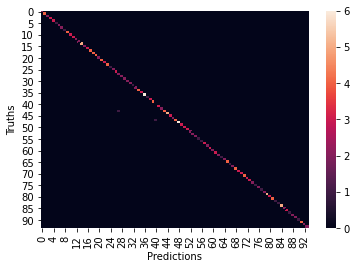

In [269]:
# Generating Confusion matrix
testSetResults = src.Manager.runTestSet(**sortedClassifiersBestF1Score['KernelModel']['pipeline'])
predictions = testSetResults['predictions']
truths = testSetResults['truths']
sns.heatmap(confusion_matrix(truths,predictions))
plt.xlabel('Predictions')
plt.ylabel('Truths')
plt.show()

Le diagonal de la matrice de confusion est clair, ce qui montre qu'on eu de très bon résultats